#### Copyright 2019 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Manipulating an Image in Python

So far the data that we have encountered has been in a textual format, such as comma separated values of strings and numbers. Other data has been directly loaded from Scikit Learn as a `Bunch` of NumPy arrays, also containing strings and numbers.

Data scientists will sometimes find themselves working with collections of images, which are represented in a much more compact binary format.

Often these images are contained in a zip file, but they can also just be in a directory on your computer, stored somewhere on the internet, or in any of many other potential types of locations. It is often the job of the data scientist to gather these images in a central location for processing.

Once you have the images, you'll typically need to perform some type of modification on them before you can feed them to your model.

Most models expect a specific size of image, so you'll need to resize images you feed your model if they differ from what is expected. Resizing might including cropping, stretching, padding, and/or scaling an image. Resizing to a smaller size also helps speed up your model by reducing the size of the input data.

Images can also be encoded in many different ways. Some are grayscale, others are color. Color images might be encoded red-green-blue (RGB), blue-green-red (BRG), rgb-alpha, bgr-alpha, hue-saturation-lightness (HSL), hue-saturation-value (HSV), or some other encoding scheme. You will need to make sure your input images encoding for all of your training data is the same.

It is also common to normalize or standardize your images, which are just two different ways of reducing a wide range of pixel values (typically 0 to 255 inclusive) into a tighter range.

There are even strategies for increasing the size of your dataset by using the same image rotated different ways or cropped in different ways to introduce some variance.

This might all sound like a lot of work... and it is, but luckily you don't have to worry too much about the details. There are numerous Python toolkits for manipulating images. In this unit, we will use the [Image](https://pillow.readthedocs.io/en/stable/reference/Image.html) and [ImageOps](https://pillow.readthedocs.io/en/stable/reference/ImageOps.html) modules from the [PIL, now called Pillow](https://python-pillow.org/) library.

## Overview

### Learning Objectives

* Read and write an image file
* Resize, pad, and change the orientation of an image


### Prerequisites

* Intermediate Python

### Estimated Duration

60 minutes

### Grading Criteria

Each exercise is worth 3 points. The rubric for calculating those points is:

| Points | Description |
|--------|-------------|
| 0      | No attempt at exercise |
| 1      | Attempted exercise, but code does not run |
| 2      | Attempted exercise, code runs, but produces incorrect answer |
| 3      | Exercise completed successfully |

There are 2 exercises in this Colab so there are 6 points available. The grading scale will be 3 points.

## Get image

For this Colab we'll work with just one image.

We'll source the image from [Pixabay](https://pixabay.com/photos/running-shoe-shoe-brooks-371624/). On the image page you'll see the option to download. Choose the 1920x1280 version of the image.

After you have download the image to your local computer, rename it "sneaker.jpg" and upload it into this Colab by running the code block below, clicking "Choose Files" in the form that appears, selecting the image that was just downloaded from the dialog box, and then pressing 'Open'. You should see messages about the file being uploaded and then eventually you'll see a notification that the file upload is complete.

In [2]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

We can now take a look at our image to see if we uploaded it properly. To do this we will use [Matplotlib](https://matplotlib.org/) to actually show the image. But first, we must load the image from the virtual machine hosting this Colab. Right now that image is stored on the virtual machine's hard drive.

We could use Python's native [open](https://docs.python.org/3/library/functions.html#open) function to load the image from disk into Python, but we'd have a binary blob of data that we'd have to decode ourselves. Instead we'll use OpenCv's imread method to open the file.


In [3]:
import cv2 as cv
import matplotlib.pyplot as plt

image = cv.imread('sneaker.jpg')

plt.imshow(image)

Does something look off there? Wasn't the shoe pink when we downloaded the image?

OpenCV loads the image as BGR instead of RGB by default, but pyplot expect an RGB image. To make it look normal, we need to switch the order of B, G, and R. 

This can be done by calling the `cvtColor` method in OpenCV, but there's a simple way to do this just using Numpy, since OpenCV images are just Numpy arrays!! Use whichever you prefer.

Here's the OpenCV way:

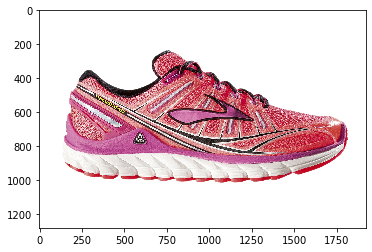

In [4]:
corrected_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.imshow(corrected_image)


The Numpy way depends on the fact that images are 3-dimensional Numpy arrays. To see this, let's check the shape:

In [5]:
image.shape

(1280, 1920, 3)

This tells us there are 1280 rows and 1920 columns of pixels, and three color channels, corresponding to amounts of Blue, Green, and Red at each pixel. To swap the colors, we just reindex in the third coordinate:

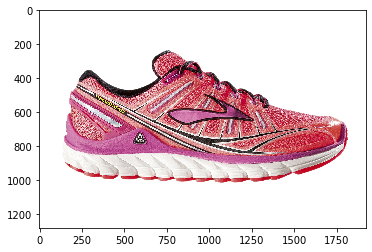

In [6]:
corrected_image= image[:,:,::-1] #reverses order of B,G,and R

plt.imshow(corrected_image)

## Reshaping

The image we currently have is wider than it is tall (landscape). It could have just as easily been taller than it is wide (portrait). It could have even been a square.

Does the model care? *No... and Yes.*

The model simply wants consistent inputs. These could be of any shape, but we have to decide on one and stick with it.

Maybe we are always processing images in a specific aspect ratio, maybe we aren't. If we are then we are guaranteed to always use the same aspect ratio for the model the reshaping might not be necessary. If the input images might differ in aspect ratio, then reshaping is a critical skill... let's see how to do it.

Above we determined that the size of the image we are working with was 1280 by 1920.

Now we have to figure out *if* and *how* to reshape it.

For the question of *if*, let's assume that we expect a variable set of input shapes and based on this we believe that reshaping is necessary.

Now we need to think about *how* to reshape the image. *How* can take many different formats:

* Do we find the smaller dimension and just add blank padding to it until it is the same size as the larger dimension?
 * If so, do we pad one side? Both?
 * And what pixel value(s) do we use for the padding? Min? Max? Average? Other?
* Do we crop a fixed portion of the image?
 * If so do we center? Randomly crop? Multiple times?
* Do we simply resize the image and let it be proportionally distorted?

The answer to all of these questions is both *yes* and *no* while also *other*. It completely depends on your problem domain and use case. This is actually part of the **science** of data science. Hypothesize, experiment, repeat.

But for this Colab we have to make a definitive decision. For simplicity we will choose to evenly pad the smaller dimension with the max pixel values as evenly as possible on either side.

To do this we first need to find the larger side (height or width) of the image.

In [7]:
max_dimension = max(image.shape[:2])

print(max_dimension)

1920


Not completely unexpected. 1920 is definitely larger than 1280.

Now we need to find out how much padding we need to add to each side of the image. The longer side shouldn't get any extra padding and the shorter side should get enough padding to make it equal to the longer side since we are making the image a square.

In this case, we have a landscape picture so no extra width is needed and 640 pixels of height is needed.

In [8]:
height_padding = max_dimension - image.shape[0]
width_padding = max_dimension - image.shape[1]

print("Width padding: {}, Height padding: {}".format(width_padding, height_padding))

Width padding: 0, Height padding: 640


We don't want all of the padding to go to one side of the image though. We need to split the amount of padding in half and then add each half of the padding to each side of the shorter dimension of the image.

There is a problem when the padding is an odd number of pixels. A half of a pixel doesn't make sense, so instead we just need to choose a side of the image to put the extra bit of padding onto. In order to do this we first do integer division to split the padding in half and then use subtraction to find the size of the other portion of the padding.

In [9]:
left_padding = width_padding // 2
right_padding = width_padding - left_padding

top_padding = height_padding // 2
bottom_padding = height_padding - top_padding

print("Left padding: {}, Top padding {}, Right padding: {}, Bottom padding {}".format(
  left_padding, 
  top_padding, 
  right_padding, 
  bottom_padding))

Left padding: 0, Top padding 320, Right padding: 0, Bottom padding 320


Now that we know how much padding to add to the image, we can do so by asking OpenCV to expand the image.

In this case we asked for the padding to be white (RGB all 255). This made sense because this particular image contains one "object" and a solid white background. If your images are not so well produced, you might need to use a different strategy for coloring the image padding.

We could do this by manipulating Numpy arrays, but in this case its easier to call an OpenCV method:

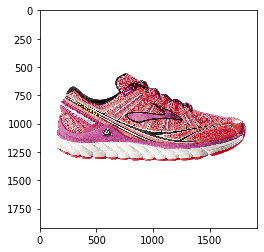

In [10]:
padded_image= cv.copyMakeBorder(corrected_image,top_padding,bottom_padding,left_padding,right_padding,cv.BORDER_CONSTANT,value=[255,255,255])

plt.imshow(padded_image)

We will do one final check to confirm that the image is indeed a square now. You should now have a 1920x1920 image.

In [11]:
padded_image.shape

(1920, 1920, 3)

## Scale the Image

1920x1920 is a pretty big image for a machine learning model to handle. If each pixel were used as input that would be 3,686,400 values in the input vector for a model. It is common for each pixel to have three or four channels for a color image: red, green, blue, alpha. If there are four channels the actual number of inputs is closer to 14,745,600 for this image.

A common strategy to reduce the size of the inputs is to simply reduce the size of the image by scaling it down. Let's use OpenCV to do that.

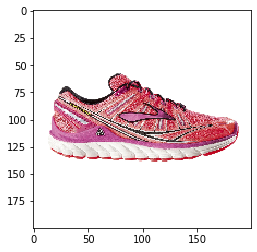

In [12]:
desired_size = (200, 200)

resized_image = cv.resize(padded_image, desired_size)

plt.imshow(resized_image)

We can see the exact size of the resized image.

In [13]:
resized_image.shape

(200, 200, 3)

Padding before resizing allowed us to not distort the shape of the contents of our image, but it did require that we apply an artificial background.

We could have also just scaled the image into a 200x200 square and distorted the image.

Which is better? It really depends on what type of image you have coming into your system and the problem you are trying to solve.

### Drawing Rectangles on Images

As part of this workshop we want to draw a rectangle around objects we identify. This can be done with the OpenCV `rectangle` method.

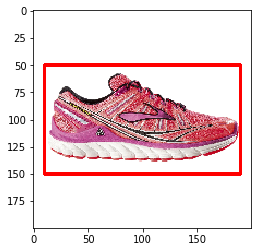

In [14]:
left = 10
right = 190
top = 50
bottom = 150

r = 255
g = 0
b = 0

cv.rectangle(resized_image, (left, top), (right, bottom), (r, g, b), thickness=2)
plt.imshow(resized_image)
plt.show()

### Drawing Text on Images

You can also draw text on images.

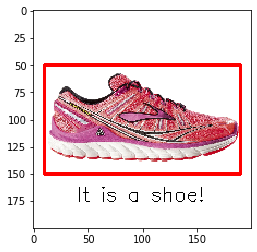

In [15]:
left = 40
top = 175

r = 0
g = 0
b = 0
scale = 0.6
thickness = 1

cv.putText(resized_image, "It is a shoe!", (left, top), cv.FONT_HERSHEY_SIMPLEX, scale, [r, g, b], thickness)

plt.imshow(resized_image)
plt.show()

# Exercises

## Exercise 1

Your turn!  Load and view [this image of a car](https://pixabay.com/illustrations/car-sports-car-racing-car-speed-49278/) from Pixabay and then upload it to this colab.

Then correct the color and make it square and a size of 100 by 100 pixels.  Finally, draw a blue rectangle around the car and add some text to label it.

### Student Solution

In [16]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

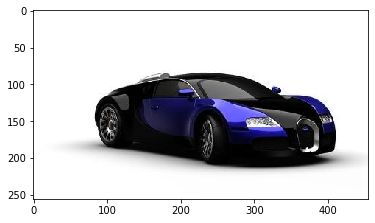

In [17]:
import cv2 as cv
import matplotlib.pyplot as plt

image = cv.imread('car.jpg')

plt.imshow(image)

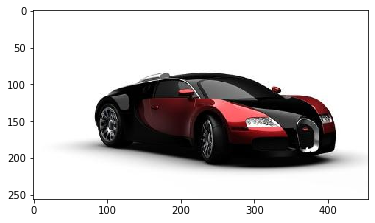

In [18]:
corrected_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
corrected_image.shape
plt.imshow(corrected_image)

(455, 455, 3)

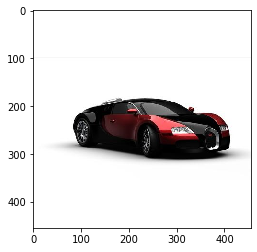

In [19]:
#Your code here
corrected_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
corrected_image.shape
max_dimension = max(image.shape[:2])

height_padding = max_dimension - image.shape[0]
width_padding = max_dimension - image.shape[1]

left_padding = width_padding // 2
right_padding = width_padding - left_padding
top_padding = height_padding // 2
bottom_padding = height_padding - top_padding

padded_image= cv.copyMakeBorder(corrected_image,top_padding,bottom_padding,left_padding,right_padding,cv.BORDER_CONSTANT,value=[255,255,255])
plt.imshow(padded_image)
padded_image.shape


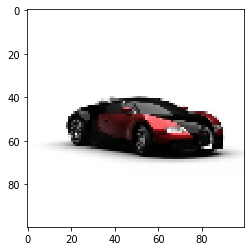

In [20]:
desired_size = (100, 100)
resized_image = cv.resize(padded_image, desired_size)
plt.imshow(resized_image)

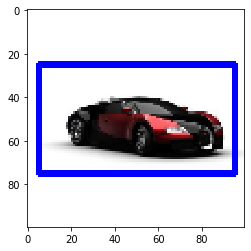

In [21]:
left = 5
right = 95
top = 25
bottom = 75

r = 0
g = 0
b = 255

cv.rectangle(resized_image, (left, top), (right, bottom), (r, g, b), thickness=2)
plt.imshow(resized_image)
plt.show()

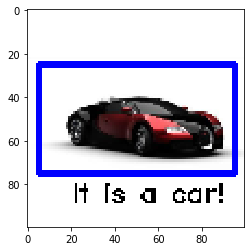

In [22]:
left = 20
top = 88

r = 0
g = 0
b = 0
scale = 0.4
thickness = 1

cv.putText(resized_image, "It is a car!", (left, top), cv.FONT_HERSHEY_DUPLEX, scale, [r, g, b], thickness)

plt.imshow(resized_image)
plt.show()

## Exercise 2

For the color-corrected car image you made in the previous exercise, do the following:

1.  Flip the image horizontally (left to right) using  an OpenCV method.
2.  Flip the image vertically (top to bottom) using Numpy array reindexing.
3. Make the car Green by swapping color channels.





### Student Solution

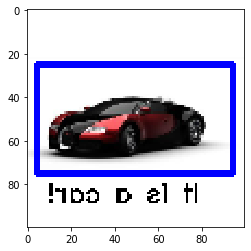

In [23]:
### YOUR CODE HERE ###

# Flip the image horizontally (left to right) using an OpenCV method

horizontally_image = cv.flip(resized_image,flipCode=1)

# Plot the image to show the image is indeed flipped horizontally

plt.imshow(horizontally_image)

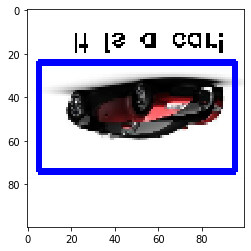

In [24]:
### YOUR CODE HERE ###
import numpy as np
# Flip the image vertically  (top to bottom) using Numpy array reindexing

vertically_image = np.flip(resized_image,0)

# Plot the image to show the image is indeed flipped vertically 

plt.imshow(vertically_image)

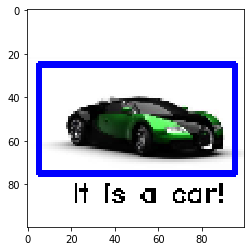

In [25]:
### YOUR CODE HERE ###

# Make the car green

red = resized_image[:,:,0].copy()
green = resized_image[:,:,1].copy()

resized_image[:,:,1] = red
resized_image[:,:,0] = green
plt.imshow(resized_image)